In [1]:
import torch
import os
import math
import time
import pynvml
import yaml
os.environ['CUDA_VISIBLE_DEVICES'] = '6, 7'
import sys
import random
sys.path.append('/home/yang_liu/python_workspace/3DGS')
import torchvision
from os import makedirs
from torch import nn


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scene.datasets import GSDataset
from scene import LargeScene, GaussianModel, GaussianModelLOD
from gaussian_renderer import render, render_v2, render_v3
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from arguments import GroupParams
from utils.general_utils import PILtoTorch
from utils.graphics_utils import getWorld2View2, getProjectionMatrix
from utils.large_utils import which_block, block_filtering
from utils.sh_utils import eval_sh
from transforms3d.euler import euler2mat, mat2euler

WARNED = False

In [2]:
class BlockedGaussian:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0):
        self.xyz = []
        self.opacity = []
        self.rotation = []
        self.scaling = []
        self.features = []
        self.cov3D = []
        self.cell_corners = []
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians):
        with torch.no_grad():
            xyz = gaussians.get_xyz
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, xyz, self.aabb, self.block_dim, self.scale)
                self.xyz.append(xyz[cell_mask])
                self.opacity.append(gaussians.get_opacity[cell_mask])
                self.rotation.append(gaussians.get_rotation[cell_mask])
                self.scaling.append(gaussians.get_scaling[cell_mask])
                self.features.append(gaussians.get_features[cell_mask])
                self.cov3D.append(gaussians.get_covariance(self.scale)[cell_mask])
                xyz_min = xyz[cell_mask].min(dim=0)[0]
                xyz_max = xyz[cell_mask].max(dim=0)[0]
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=xyz.device)
                self.cell_corners.append(corners)
    
    def get_xyz(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.xyz[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out

    def get_opacity(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.opacity[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out
    
    def get_rotation(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.rotation[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out
    
    def get_scaling(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.scaling[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out
    
    def get_features(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.features[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out
    
    def get_cov3D(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.cov3D[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out

class BlockedGaussianV2:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0, compute_cov3D_python=False):
        self.feats = []
        self.cell_corners = []
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device
        self.compute_cov3D_python = compute_cov3D_python

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians):
        with torch.no_grad():
            xyz = gaussians.get_xyz
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, xyz, self.aabb, self.block_dim, self.scale)
                if self.compute_cov3D_python:
                    geometry = gaussians.get_covariance(self.scale)[cell_mask].to(self.device)
                else:
                    geometry = torch.cat([gaussians.get_scaling[cell_mask],
                                          gaussians.get_rotation[cell_mask]], dim=1)

                self.feats.append(torch.cat([xyz[cell_mask], 
                                             gaussians.get_opacity[cell_mask],  
                                             gaussians.get_features[cell_mask].reshape(cell_mask.sum(), -1),
                                             geometry], dim=1))
                xyz_min = xyz[cell_mask].min(dim=0)[0]
                xyz_max = xyz[cell_mask].max(dim=0)[0]
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=xyz.device)
                self.cell_corners.append(corners)
    
    def get_feats(self, indices):
        out = []
        if len(indices) > self.range[0]:
            indice_end = min(len(indices), self.range[1])
            out = [self.feats[indices[i].item()] for i in range(self.range[0], indice_end)]
        return out

class BlockedGaussianV3:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0, compute_cov3D_python=False):
        self.cell_corners = []
        self.feats = None
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device
        self.compute_cov3D_python = compute_cov3D_python
        self.cell_ids = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.long, device=self.device)
        self.mask = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.bool, device=self.device)

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians, n=4):
        with torch.no_grad():
            if self.compute_cov3D_python:
                geometry = gaussians.get_covariance(self.scale).to(self.device)
            else:
                geometry = torch.cat([gaussians.get_scaling,
                                      gaussians.get_rotation], dim=1)
            self.feats = torch.cat([gaussians.get_xyz,
                                    gaussians.get_opacity,  
                                    gaussians.get_features.reshape(geometry.shape[0], -1),
                                    geometry], dim=1)

            xyz = gaussians.get_xyz
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, self.feats[:, :3], self.aabb, self.block_dim, self.scale)
                self.cell_ids[cell_mask] = cell_idx
                # MAD to eliminate influence of outsiders
                xyz_median = torch.median(xyz[cell_mask], dim=0)[0]
                delta_median = torch.median(torch.abs(xyz[cell_mask] - xyz_median), dim=0)[0]
                xyz_min = xyz_median - n * delta_median
                xyz_min = torch.max(xyz_min, torch.min(xyz[cell_mask], dim=0)[0])
                xyz_max = xyz_median + n * delta_median
                xyz_max = torch.min(xyz_max, torch.max(xyz[cell_mask], dim=0)[0])
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=xyz.device)
                self.cell_corners.append(corners)
    
    def get_feats(self, indices):
        out = torch.tensor([], device=self.device, dtype=self.feats.dtype)
        if len(indices) > self.range[0]:
            indice_end = min(len(indices), self.range[1])
            self.mask = torch.isin(self.cell_ids, indices[self.range[0]:indice_end].to(self.device))
            out = self.feats[self.mask]
        return out

class BlockedGaussianV4:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0, compute_cov3D_python=False):
        self.cell_corners = []
        self.feats = None
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device
        self.compute_cov3D_python = compute_cov3D_python
        self.cell_ids = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.long, device=self.device)
        self.mask = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.bool, device=self.device)

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians, n=4):
        with torch.no_grad():
            if self.compute_cov3D_python:
                geometry = gaussians.get_covariance(self.scale).to(self.device)
            else:
                geometry = torch.cat([gaussians.get_scaling,
                                      gaussians.get_rotation], dim=1)
            self.feats = torch.cat([gaussians.get_xyz,
                                    gaussians.get_opacity,  
                                    gaussians.get_features.reshape(geometry.shape[0], -1),
                                    geometry], dim=1)

            xyz = gaussians.get_xyz
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, self.feats[:, :3], self.aabb, self.block_dim, self.scale)
                self.cell_ids[cell_mask] = cell_idx
                # MAD to eliminate influence of outsiders
                xyz_median = torch.median(xyz[cell_mask], dim=0)[0]
                delta_median = torch.median(torch.abs(xyz[cell_mask] - xyz_median), dim=0)[0]
                xyz_min = xyz_median - n * delta_median
                xyz_min = torch.max(xyz_min, torch.min(xyz[cell_mask], dim=0)[0])
                xyz_max = xyz_median + n * delta_median
                xyz_max = torch.min(xyz_max, torch.max(xyz[cell_mask], dim=0)[0])
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=xyz.device)
                self.cell_corners.append(corners)
    
    def get_feats(self, indices, distances):
        out = torch.tensor([], device=self.device, dtype=self.feats.dtype)
        block_mask = (distances >= self.range[0]) & (distances < self.range[1])
        if block_mask.sum() > 0:
            self.mask = torch.isin(self.cell_ids, indices[block_mask].to(self.device))
            out = self.feats[self.mask]
        return out


class Camera(nn.Module):
    def __init__(self, colmap_id, R, T, FoVx, FoVy, image, gt_alpha_mask,
                 image_name, uid,
                 trans=np.array([0.0, 0.0, 0.0]), scale=1.0, data_device = "cuda"
                 ):
        super(Camera, self).__init__()

        self.uid = uid
        self.colmap_id = colmap_id
        self.R = R
        self.T = T
        self.FoVx = FoVx
        self.FoVy = FoVy
        self.image_name = image_name

        try:
            self.data_device = torch.device(data_device)
        except Exception as e:
            print(e)
            print(f"[Warning] Custom device {data_device} failed, fallback to default cuda device" )
            self.data_device = torch.device("cuda")

        self.original_image = image.clamp(0.0, 1.0).to(self.data_device)
        self.image_width = self.original_image.shape[2]
        self.image_height = self.original_image.shape[1]

        if gt_alpha_mask is not None:
            self.original_image *= gt_alpha_mask.to(self.data_device)
        else:
            self.original_image *= torch.ones((1, self.image_height, self.image_width), device=self.data_device)

        self.zfar = 100.0
        self.znear = 0.01

        self.trans = trans
        self.scale = scale

        # world_view_transform = getWorld2View2(R, T, trans, scale)
        # if angle_delta is not None:
        #     R = world_view_transform[:3, :3]
        #     euler = np.array(mat2euler(R)) * 180 / np.pi
        #     euler += angle_delta
        #     R = euler2mat(*euler * np.pi / 180)
        #     world_view_transform[:3, :3] = R

        self.world_view_transform = torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1).cuda()
        self.projection_matrix = getProjectionMatrix(znear=self.znear, zfar=self.zfar, fovX=self.FoVx, fovY=self.FoVy).transpose(0,1).cuda()
        self.full_proj_transform = (self.world_view_transform.unsqueeze(0).bmm(self.projection_matrix.unsqueeze(0))).squeeze(0)
        self.camera_center = self.world_view_transform.inverse()[3, :3]

def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def in_frustum(viewpoint_cam, cell_corners, aabb, block_dim):
    num_cell = cell_corners.shape[0]
    device = cell_corners.device

    cell_corners = torch.cat([cell_corners, torch.ones_like(cell_corners[..., [0]])], dim=-1)
    cam_center = viewpoint_cam.camera_center
    full_proj_transform = viewpoint_cam.full_proj_transform.repeat(num_cell, 1, 1)
    viewmatrix = viewpoint_cam.world_view_transform.repeat(num_cell, 1, 1)
    cell_corners_screen = cell_corners.bmm(full_proj_transform)
    cell_corners_screen = cell_corners_screen / cell_corners_screen[..., [-1]]
    cell_corners_screen = cell_corners_screen[..., :-1]

    cell_corners_cam = cell_corners.bmm(viewmatrix)
    mask = (cell_corners_cam[..., 2] > 0.2)

    cell_corners_screen_min = torch.zeros((num_cell, 3), dtype=torch.float32, device=device)
    cell_corners_screen_max = torch.zeros((num_cell, 3), dtype=torch.float32, device=device)

    for i in range(num_cell):
        if mask[i].sum() > 0:
            cell_corners_screen_min[i] = cell_corners_screen[i][mask[i]].min(dim=0).values
            cell_corners_screen_max[i] = cell_corners_screen[i][mask[i]].max(dim=0).values

    box_a = torch.cat([cell_corners_screen_min[:, :2], cell_corners_screen_max[:, :2]], dim=1)
    box_b = torch.tensor([[-1, -1, 1, 1]], dtype=torch.float32, device=device)
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                    box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                    box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    mask = (inter[:, 0, 0] * inter[:, 0, 1]) > 0

    cam_center_id = which_block(cam_center[None, :], aabb, block_dim)[0]
    mask[cam_center_id] = True

    return mask

def load_gaussians(cfg, config_name, iteration=30_000, load_vq=False, deivce='cuda', source_path='../data/matrix_city/aerial/test/block_all_test'):
    
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', cfg)
    lp.source_path = source_path
    lp.model_path = os.path.join("../output/", config_name)

    modules = __import__('scene')
    
    with torch.no_grad():
        if 'apply_voxelize' in lp.model_config['kwargs'].keys():
            lp.model_config['kwargs']['apply_voxelize'] = False
        gaussians = getattr(modules, lp.model_config['name'])(lp.sh_degree, device=deivce, **lp.model_config['kwargs'])
        scene = LargeScene(lp, gaussians, load_iteration=iteration, load_vq=load_vq, shuffle=False)
        print(f'Init {config_name} with {len(gaussians.get_opacity)} points\n')

    return gaussians, scene

def loadCam(args, id, cam_info, resolution_scale, angle_delta=None):
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    resized_image_rgb = PILtoTorch(cam_info.image, resolution)

    gt_image = resized_image_rgb[:3, ...]
    loaded_mask = None

    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    if angle_delta is not None:
        Rt = np.zeros((4, 4))
        Rt[:3, :3] = cam_info.R.transpose()
        Rt[:3, 3] = cam_info.T
        Rt[3, 3] = 1.0

        C2W = np.linalg.inv(Rt)
        euler = np.array(mat2euler(C2W[:3, :3])) * 180 / np.pi
        euler += angle_delta
        C2W[:3, :3] = euler2mat(*euler * np.pi / 180)
        Rt = np.linalg.inv(C2W)

        R = Rt[:3, :3].transpose()
        T = Rt[:3, 3]
    else:
        R = cam_info.R
        T = cam_info.T

    return Camera(colmap_id=cam_info.uid, R=R, T=T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

def loadCamV2(args, id, cam_info, resolution_scale, pitch=None, height=None):
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    resized_image_rgb = PILtoTorch(cam_info.image, resolution)

    gt_image = resized_image_rgb[:3, ...]
    loaded_mask = None

    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    if height is not None and pitch is not None:
        Rt = np.zeros((4, 4))
        Rt[:3, :3] = cam_info.R.transpose()
        Rt[:3, 3] = cam_info.T
        Rt[3, 3] = 1.0

        C2W = np.linalg.inv(Rt)
        euler = np.array(mat2euler(C2W[:3, :3])) * 180 / np.pi
        euler[0] = pitch
        C2W[:3, :3] = euler2mat(*euler * np.pi / 180)
        C2W[2, -1] = height
        Rt = np.linalg.inv(C2W)

        R = Rt[:3, :3].transpose()
        T = Rt[:3, 3]
    else:
        R = cam_info.R
        T = cam_info.T

    return Camera(colmap_id=cam_info.uid, R=R, T=T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

def render_lod(viewpoint_cam, lod_list : list, pipe, bg_color : torch.Tensor, scaling_modifier = 1.0, override_color = None):
        
        # sort cells by distance to camera

        in_frustum_mask = in_frustum(viewpoint_cam, lod_list[-1].cell_corners, lod_list[-1].aabb, lod_list[-1].block_dim)
        in_frustum_indices = in_frustum_mask.nonzero().squeeze(0)
        cam_center = viewpoint_cam.camera_center
        distance3D = torch.norm(lod_list[-1].cell_corners[in_frustum_mask, :, :3] - cam_center[:3], dim=2).min(dim=1).values
        in_frustum_indices = in_frustum_indices[torch.sort(distance3D)[1]]
        distance3D = torch.sort(distance3D)[0]
        
        # used for BlockedGaussianV3
        out_list = []
        main_device = lod_list[-1].feats.device
        max_sh_degree = lod_list[-1].max_sh_degree
        feat_end_dim = 3 * (max_sh_degree + 1) ** 2 + 4
        
        for lod_gs in lod_list:
            out_i = lod_gs.get_feats(in_frustum_indices, distance3D)
            if out_i.shape[0] == 0:
                continue
            if out_i.device != main_device:
                out_i = torch.cat([out_i[:, :3].to(main_device), out_i[:, 3:].half().to(main_device)], dim=1)
            out_list.append(out_i)

        feats = torch.cat(out_list, dim=0)
        # feats = lod_list[2].feats

        means3D = feats[:, :3]
        screenspace_points = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
        means2D = screenspace_points
        opacity = feats[:, 3]
        # If precomputed 3d covariance is provided, use it. If not, then it will be computed from
        # scaling / rotation by the rasterizer.
        scales = None
        rotations = None
        cov3D_precomp = None
        if pipe.compute_cov3D_python:
            cov3D_precomp = feats[:, feat_end_dim:]
        else:
            scales = feats[:, feat_end_dim:feat_end_dim+3]
            rotations = feats[:, (feat_end_dim+3):]
            
        # If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
        # from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
        shs = None
        colors_precomp = None
        if override_color is None:
            features = feats[:, 4:feat_end_dim].reshape(-1, (max_sh_degree+1)**2, 3)
            if pipe.convert_SHs_python:
                shs_view = features.transpose(1, 2).view(-1, 3, (max_sh_degree+1)**2)
                dir_pp = (means3D - viewpoint_cam.camera_center.repeat(features.shape[0], 1))
                dir_pp_normalized = dir_pp/dir_pp.norm(dim=1, keepdim=True)
                sh2rgb = eval_sh(max_sh_degree, shs_view, dir_pp_normalized)
                colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
            else:
                shs = features
        else:
            colors_precomp = override_color  # check if requires masking
        
        # Set up rasterization configuration
        tanfovx = math.tan(viewpoint_cam.FoVx * 0.5)
        tanfovy = math.tan(viewpoint_cam.FoVy * 0.5)

        raster_settings = GaussianRasterizationSettings(
            image_height=int(viewpoint_cam.image_height),
            image_width=int(viewpoint_cam.image_width),
            tanfovx=tanfovx,
            tanfovy=tanfovy,
            bg=bg_color,
            scale_modifier=scaling_modifier,
            viewmatrix=viewpoint_cam.world_view_transform,
            projmatrix=viewpoint_cam.full_proj_transform,
            sh_degree=max_sh_degree,
            campos=viewpoint_cam.camera_center, 
            prefiltered=False,
            debug=pipe.debug
        )

        rasterizer = GaussianRasterizer(raster_settings=raster_settings)

        rendered_image, radii = rasterizer(
            means3D = means3D,
            means2D = means2D,
            shs = shs,
            colors_precomp = colors_precomp,
            opacities = opacity,
            scales = scales,
            rotations = rotations,
            cov3D_precomp = cov3D_precomp)
        
        # Those Gaussians that were frustum culled or had a radius of 0 were not visible.
        # They will be excluded from value updates used in the splitting criteria.
        return {"render": rendered_image,
                "viewspace_points": screenspace_points,
                "visibility_filter" : radii > 0,
                "radii": radii}

## 1. Render with GS in CPU

In [3]:
iteration = 40_000

config_2 = '../config/block_mc_aerial_block_all_lr_c36_loss_5_75_lr64_distill.yaml'
config_name_2 = os.path.splitext(os.path.basename(config_2))[0]
with open(config_2) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg['model_params']['model_config']['name'] = "GaussianModelVoxV2"
lod_gs_2, scene = load_gaussians(cfg, config_name_2, iteration=iteration)

config_1 = '../config/block_mc_aerial_block_all_lr_c36_loss_5_66_lr64_distill.yaml'
config_name_1 = os.path.splitext(os.path.basename(config_1))[0]
with open(config_1) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg['model_params']['model_config']['name'] = "GaussianModelVoxV2"
lod_gs_1, _ = load_gaussians(cfg, config_name_1, iteration=iteration)

config_0 = '../config/block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_distill.yaml'
config_name_0 = os.path.splitext(os.path.basename(config_0))[0]
with open(config_0) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg['model_params']['model_config']['name'] = "GaussianModelVoxV2"
lod_gs_0, _ = load_gaussians(cfg, config_name_0, iteration=iteration, deivce='cuda:1')

Loading trained model at iteration 40000
Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_75_lr64_distill with 5891401 points

Loading trained model at iteration 40000
Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_66_lr64_distill with 8012304 points

Loading trained model at iteration 40000
Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_distill with 11782801 points



In [4]:
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from scene.gaussian_model import GaussianModel
from utils.sh_utils import eval_sh
import math
import time

In [5]:
lp, op, pp = parse_cfg(cfg)
setattr(lp, 'config_path', cfg)
lp.source_path = '../data/matrix_city/aerial/test/block_all_test'
lod_threshold = [0, 2.5, 3.5, torch.inf]
# render() params
scaling_modifier = 1.0
override_color = None
angle_delta = None

In [ ]:
xyz = lod_gs_0.get_xyz

# get lookup table for level 1
voxel_index_1 = torch.div(xyz[:, :3].clone().detach().float().cuda() - lod_gs_0.xyz_range[None, :3], lod_gs_1.voxel_size[None, :], rounding_mode='floor')
voxel_coords_1 = voxel_index_1 * lod_gs_1.voxel_size[None, :] + lod_gs_0.xyz_range[None, :3] + lod_gs_1.voxel_size[None, :] / 2
new_coors_1, unq_inv_1 = torch.unique(voxel_coords_1, return_inverse=True, return_counts=False, dim=0)
assert new_coors_1.shape[0] == lod_gs_1.get_xyz.shape[0]

# get lookup table for level 2
voxel_index_2 = torch.div(xyz[:, :3].clone().detach().float().cuda() - lod_gs_0.xyz_range[None, :3], lod_gs_2.voxel_size[None, :], rounding_mode='floor')
voxel_coords_2 = voxel_index_2 * lod_gs_2.voxel_size[None, :] + lod_gs_0.xyz_range[None, :3] + lod_gs_2.voxel_size[None, :] / 2
new_coors_2, unq_inv_2 = torch.unique(voxel_coords_2, return_inverse=True, return_counts=False, dim=0)
assert new_coors_2.shape[0] == lod_gs_2.get_xyz.shape[0]

## 2. Visualization & Analysis

Indexing time: 0.0941s
Masking time: 0.6523s
Rasterization time: 0.0189s


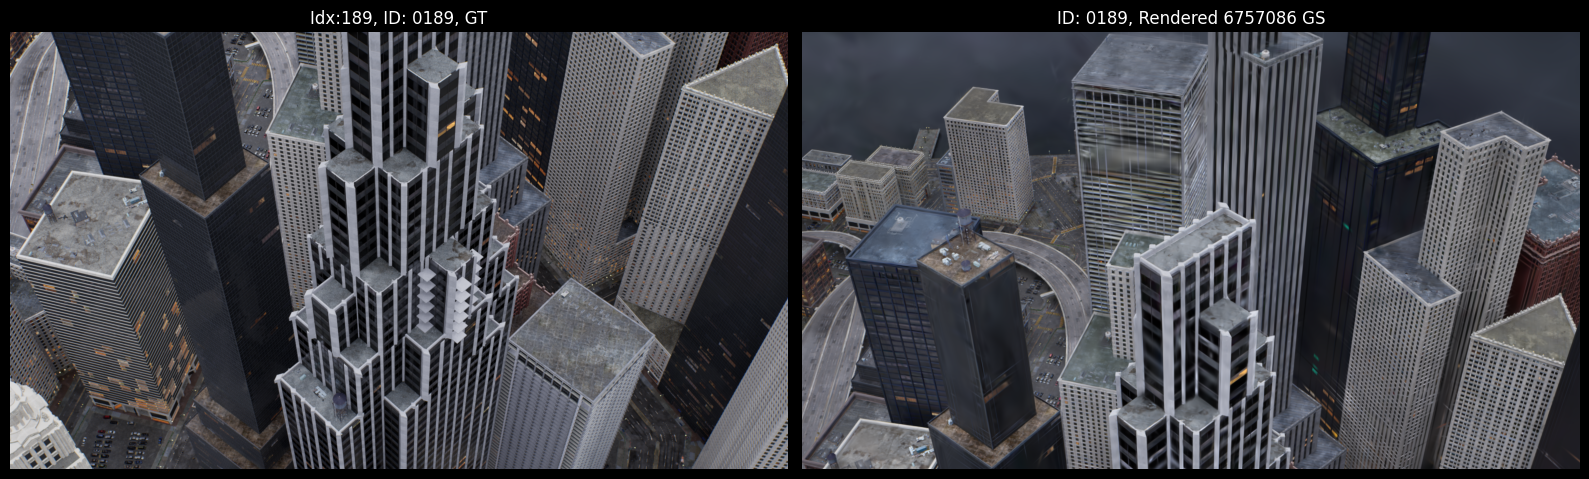

In [ ]:
with torch.no_grad():
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    idx = random.randint(0, len(views)-1)
    # idx = 101

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    viewpoint_cam = loadCam(lp, id, views[idx], 1.0, angle_delta)
    
    start = time.time()
    cam_center = viewpoint_cam.camera_center.cpu()
    distance3D = torch.norm(lod_gs_0.get_xyz - cam_center, dim=1)
    mask_list = [(distance3D >= lod_threshold[i]) & (distance3D < lod_threshold[i+1]) for i in range(len(lod_threshold)-1)]
    
    level_1_idx = torch.unique(unq_inv_1[mask_list[1]])
    level_2_idx = torch.unique(unq_inv_2[mask_list[2]])

    end = time.time()
    print(f'Indexing time: {end-start:.4f}s')

    start = time.time()
    means3D = torch.cat([lod_gs_0.get_xyz[mask_list[0]].cuda(), lod_gs_1.get_xyz[level_1_idx], lod_gs_2.get_xyz[level_2_idx]], dim=0)
    screenspace_points = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
    means2D = screenspace_points
    opacity = torch.cat([lod_gs_0.get_opacity[mask_list[0]].cuda(), lod_gs_1.get_opacity[level_1_idx], lod_gs_2.get_opacity[level_2_idx]], dim=0)

    # If precomputed 3d covariance is provided, use it. If not, then it will be computed from
    # scaling / rotation by the rasterizer.
    scales = None
    rotations = None
    cov3D_precomp = None
    if pp.compute_cov3D_python:
        cov3D_precomp = torch.cat([lod_gs_0.get_covariance(scaling_modifier)[mask_list[0]].cuda(), lod_gs_1.get_covariance(scaling_modifier)[level_1_idx], 
                                lod_gs_2.get_covariance(scaling_modifier)[level_2_idx]], dim=0)
    else:
        scales = torch.cat([lod_gs_0.get_scaling[mask_list[0]].cuda(), lod_gs_1.get_scaling[level_1_idx], lod_gs_2.get_scaling[level_2_idx]], dim=0)
        rotations = torch.cat([lod_gs_0.get_rotation[mask_list[0]].cuda(), lod_gs_1.get_rotation[level_1_idx], lod_gs_2.get_rotation[level_2_idx]], dim=0)

    # If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
    # from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
    shs = None
    colors_precomp = None
    if override_color is None:
        if pp.convert_SHs_python:
            features = torch.cat([lod_gs_0.get_features[mask_list[0]].cuda(), lod_gs_1.get_features[level_1_idx], lod_gs_2.get_features[level_2_idx]], dim=0)
            shs_view = features.transpose(1, 2).view(-1, 3, (lod_gs_2.max_sh_degree+1)**2)
            dir_pp = (means3D - viewpoint_cam.camera_center.repeat(features.shape[0], 1))
            dir_pp_normalized = dir_pp/dir_pp.norm(dim=1, keepdim=True)
            sh2rgb = eval_sh(lod_gs_2.active_sh_degree, shs_view, dir_pp_normalized)
            colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
        else:
            shs = torch.cat([lod_gs_0.get_features[mask_list[0]].cuda(), lod_gs_1.get_features[level_1_idx], lod_gs_2.get_features[level_2_idx]], dim=0)
    else:
        colors_precomp = override_color  # check if requires masking
    
    end = time.time()
    print(f'Masking time: {end-start:.4f}s')

    start = time.time()
    # Set up rasterization configuration
    tanfovx = math.tan(viewpoint_cam.FoVx * 0.5)
    tanfovy = math.tan(viewpoint_cam.FoVy * 0.5)

    raster_settings = GaussianRasterizationSettings(
        image_height=int(viewpoint_cam.image_height),
        image_width=int(viewpoint_cam.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_cam.world_view_transform,
        projmatrix=viewpoint_cam.full_proj_transform,
        sh_degree=lod_gs_2.active_sh_degree,
        campos=viewpoint_cam.camera_center, 
        prefiltered=False,
        debug=pp.debug
    )

    rasterizer = GaussianRasterizer(raster_settings=raster_settings)

    rendered_image, radii, geometry = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = shs,
        colors_precomp = colors_precomp,
        opacities = opacity,
        scales = scales,
        rotations = rotations,
        cov3D_precomp = cov3D_precomp)

    end = time.time()
    print(f'Rasterization time: {end-start:.4f}s')


num_GS = means3D.shape[0]
image = rendered_image.cpu().numpy().transpose(1,2,0)
image_gt = viewpoint_cam.original_image.cpu().numpy().transpose(1,2,0)
ID = viewpoint_cam.image_name

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(np.clip(image_gt, 0, 1))
plt.title(f'Idx:{idx}, ID: {ID}, GT')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.clip(image, 0, 1))
plt.title(f'ID: {ID}, Rendered {num_GS} GS')
plt.axis('off')
plt.tight_layout()

## 3. Rendering whole test dataset

In [ ]:
import torchvision
from os import makedirs

model_path = os.path.join("../output/", "lod_mc_aerial_block_all_lr_c36_loss_5")
name = "block_all_test"

In [ ]:
render_path = os.path.join(model_path, name, "ours_{}".format(iteration), "renders")
gts_path = os.path.join(model_path, name, "ours_{}".format(iteration), "gt")

makedirs(render_path, exist_ok=True)
makedirs(gts_path, exist_ok=True)

with torch.no_grad():
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    avg_num_gaussians = 0
    avg_render_time = 0
    for idx in tqdm(range(len(views))):
        bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
        bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
        viewpoint_cam = loadCam(lp, id, views[idx], 1.0, angle_delta)
        
        start = time.time()
        cam_center = viewpoint_cam.camera_center.cpu()
        distance3D = torch.norm(lod_gs_0.get_xyz - cam_center, dim=1)
        mask_list = [(distance3D >= lod_threshold[i]) & (distance3D < lod_threshold[i+1]) for i in range(len(lod_threshold)-1)]
        
        level_1_idx = torch.unique(unq_inv_1[mask_list[1]])
        level_2_idx = torch.unique(unq_inv_2[mask_list[2]])

        means3D = torch.cat([lod_gs_0.get_xyz[mask_list[0]].cuda(), lod_gs_1.get_xyz[level_1_idx], lod_gs_2.get_xyz[level_2_idx]], dim=0)
        screenspace_points = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
        means2D = screenspace_points
        opacity = torch.cat([lod_gs_0.get_opacity[mask_list[0]].cuda(), lod_gs_1.get_opacity[level_1_idx], lod_gs_2.get_opacity[level_2_idx]], dim=0)

        # If precomputed 3d covariance is provided, use it. If not, then it will be computed from
        # scaling / rotation by the rasterizer.
        scales = None
        rotations = None
        cov3D_precomp = None
        if pp.compute_cov3D_python:
            cov3D_precomp = torch.cat([lod_gs_0.get_covariance(scaling_modifier)[mask_list[0]].cuda(), lod_gs_1.get_covariance(scaling_modifier)[level_1_idx], 
                                    lod_gs_2.get_covariance(scaling_modifier)[level_2_idx]], dim=0)
        else:
            scales = torch.cat([lod_gs_0.get_scaling[mask_list[0]].cuda(), lod_gs_1.get_scaling[level_1_idx], lod_gs_2.get_scaling[level_2_idx]], dim=0)
            rotations = torch.cat([lod_gs_0.get_rotation[mask_list[0]].cuda(), lod_gs_1.get_rotation[level_1_idx], lod_gs_2.get_rotation[level_2_idx]], dim=0)

        # If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
        # from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
        shs = None
        colors_precomp = None
        if override_color is None:
            if pp.convert_SHs_python:
                features = torch.cat([lod_gs_0.get_features[mask_list[0]].cuda(), lod_gs_1.get_features[level_1_idx], lod_gs_2.get_features[level_2_idx]], dim=0)
                shs_view = features.transpose(1, 2).view(-1, 3, (lod_gs_2.max_sh_degree+1)**2)
                dir_pp = (means3D - viewpoint_cam.camera_center.repeat(features.shape[0], 1))
                dir_pp_normalized = dir_pp/dir_pp.norm(dim=1, keepdim=True)
                sh2rgb = eval_sh(lod_gs_2.active_sh_degree, shs_view, dir_pp_normalized)
                colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
            else:
                shs = torch.cat([lod_gs_0.get_features[mask_list[0]].cuda(), lod_gs_1.get_features[level_1_idx], lod_gs_2.get_features[level_2_idx]], dim=0)
        else:
            colors_precomp = override_color  # check if requires masking

        
        # Set up rasterization configuration
        tanfovx = math.tan(viewpoint_cam.FoVx * 0.5)
        tanfovy = math.tan(viewpoint_cam.FoVy * 0.5)

        raster_settings = GaussianRasterizationSettings(
            image_height=int(viewpoint_cam.image_height),
            image_width=int(viewpoint_cam.image_width),
            tanfovx=tanfovx,
            tanfovy=tanfovy,
            bg=bg_color,
            scale_modifier=scaling_modifier,
            viewmatrix=viewpoint_cam.world_view_transform,
            projmatrix=viewpoint_cam.full_proj_transform,
            sh_degree=lod_gs_2.active_sh_degree,
            campos=viewpoint_cam.camera_center, 
            prefiltered=False,
            debug=pp.debug
        )

        rasterizer = GaussianRasterizer(raster_settings=raster_settings)

        rendered_image, radii = rasterizer(
            means3D = means3D,
            means2D = means2D,
            shs = shs,
            colors_precomp = colors_precomp,
            opacities = opacity,
            scales = scales,
            rotations = rotations,
            cov3D_precomp = cov3D_precomp)

        end = time.time()
        avg_render_time += end-start
        avg_num_gaussians += means3D.shape[0]

        torchvision.utils.save_image(rendered_image, os.path.join(render_path, '{0:05d}'.format(idx) + ".png"))
        torchvision.utils.save_image(viewpoint_cam.original_image[0:3, :, :], os.path.join(gts_path, '{0:05d}'.format(idx) + ".png"))

    print(f'Average number of Gaussians: {avg_num_gaussians/len(views):.4f}')
    print(f'Average rendering time: {avg_render_time/len(views):.4f}s')

100%|██████████| 741/741 [24:02<00:00,  1.95s/it]

Average number of Gaussians: 8037804.1943
Average rendering time: 0.6401s


## 4. Render the whole test dataset without Lookup Table

In [ ]:
import torchvision
from os import makedirs

model_path = os.path.join("../output/", "lod_mc_aerial_block_all_lr_c36_loss_5_no_lookup")
name = "block_all_test"
main_device = lod_gs_2.get_xyz.device

In [ ]:
# indexing is the most time_consuming part
render_path = os.path.join(model_path, name, "ours_{}".format(iteration), "renders")
gts_path = os.path.join(model_path, name, "ours_{}".format(iteration), "gt")

makedirs(render_path, exist_ok=True)
makedirs(gts_path, exist_ok=True)

with torch.no_grad():
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    avg_num_gaussians = 0
    avg_render_time = 0
    for idx in tqdm(range(len(views))):
        bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
        bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
        viewpoint_cam = loadCam(lp, id, views[idx], 1.0, angle_delta)
        
        start = time.time()
        cam_center = viewpoint_cam.camera_center
        distance3D_0 = torch.norm(lod_gs_0.get_xyz - cam_center.to(lod_gs_0.get_xyz.device), dim=1)
        distance3D_1 = torch.norm(lod_gs_1.get_xyz - cam_center, dim=1)
        distance3D_2 = torch.norm(lod_gs_2.get_xyz - cam_center, dim=1)

        mask_0 = (distance3D_0 >= lod_threshold[0]) & (distance3D_0 < lod_threshold[1])
        mask_1 = (distance3D_1 >= lod_threshold[1]) & (distance3D_1 < lod_threshold[2])
        mask_2 = (distance3D_2 >= lod_threshold[2]) & (distance3D_2 < lod_threshold[3])

        means3D = torch.cat([lod_gs_0.get_xyz[mask_0].to(main_device), lod_gs_1.get_xyz[mask_1], lod_gs_2.get_xyz[mask_2]], dim=0)
        screenspace_points = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
        means2D = screenspace_points
        opacity = torch.cat([lod_gs_0.get_opacity[mask_0].to(main_device), lod_gs_1.get_opacity[mask_1], lod_gs_2.get_opacity[mask_2]], dim=0)

        # If precomputed 3d covariance is provided, use it. If not, then it will be computed from
        # scaling / rotation by the rasterizer.
        scales = None
        rotations = None
        cov3D_precomp = None
        if pp.compute_cov3D_python:
            cov3D_precomp = torch.cat([lod_gs_0.get_covariance(scaling_modifier)[mask_0].to(main_device), lod_gs_1.get_covariance(scaling_modifier)[mask_1], 
                                    lod_gs_2.get_covariance(scaling_modifier)[mask_2]], dim=0)
        else:
            scales = torch.cat([lod_gs_0.get_scaling[mask_0].to(main_device), lod_gs_1.get_scaling[mask_1], lod_gs_2.get_scaling[mask_2]], dim=0)
            rotations = torch.cat([lod_gs_0.get_rotation[mask_0].to(main_device), lod_gs_1.get_rotation[mask_1], lod_gs_2.get_rotation[mask_2]], dim=0)

        # If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
        # from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
        shs = None
        colors_precomp = None
        if override_color is None:
            if pp.convert_SHs_python:
                features = torch.cat([lod_gs_0.get_features[mask_0].to(main_device), lod_gs_1.get_features[mask_1], lod_gs_2.get_features[mask_2]], dim=0)
                shs_view = features.transpose(1, 2).view(-1, 3, (lod_gs_2.max_sh_degree+1)**2)
                dir_pp = (means3D - viewpoint_cam.camera_center.repeat(features.shape[0], 1))
                dir_pp_normalized = dir_pp/dir_pp.norm(dim=1, keepdim=True)
                sh2rgb = eval_sh(lod_gs_2.active_sh_degree, shs_view, dir_pp_normalized)
                colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
            else:
                shs = torch.cat([lod_gs_0.get_features[mask_0].to(main_device), lod_gs_1.get_features[mask_1], lod_gs_2.get_features[mask_2]], dim=0)
        else:
            colors_precomp = override_color  # check if requires masking

        
        # Set up rasterization configuration
        tanfovx = math.tan(viewpoint_cam.FoVx * 0.5)
        tanfovy = math.tan(viewpoint_cam.FoVy * 0.5)

        raster_settings = GaussianRasterizationSettings(
            image_height=int(viewpoint_cam.image_height),
            image_width=int(viewpoint_cam.image_width),
            tanfovx=tanfovx,
            tanfovy=tanfovy,
            bg=bg_color,
            scale_modifier=scaling_modifier,
            viewmatrix=viewpoint_cam.world_view_transform,
            projmatrix=viewpoint_cam.full_proj_transform,
            sh_degree=lod_gs_2.active_sh_degree,
            campos=viewpoint_cam.camera_center, 
            prefiltered=False,
            debug=pp.debug
        )

        rasterizer = GaussianRasterizer(raster_settings=raster_settings)

        rendered_image, radii = rasterizer(
            means3D = means3D,
            means2D = means2D,
            shs = shs,
            colors_precomp = colors_precomp,
            opacities = opacity,
            scales = scales,
            rotations = rotations,
            cov3D_precomp = cov3D_precomp)

        end = time.time()
        avg_render_time += end-start
        avg_num_gaussians += means3D.shape[0]

        # torchvision.utils.save_image(rendered_image, os.path.join(render_path, '{0:05d}'.format(idx) + ".png"))
        # torchvision.utils.save_image(viewpoint_cam.original_image[0:3, :, :], os.path.join(gts_path, '{0:05d}'.format(idx) + ".png"))

    print(f'Average number of Gaussians: {avg_num_gaussians/len(views):.4f}')
    print(f'Average rendering time: {avg_render_time/len(views):.4f}s')

  0%|          | 0/741 [00:00<?, ?it/s]

  0%|          | 1/741 [00:00<01:50,  6.72it/s]

Indexing time: 0.0019s
Concatenation time: 0.0005s
Indexing time: 0.0018s
Concatenation time: 0.0001s


  0%|          | 3/741 [00:00<02:06,  5.84it/s]

Indexing time: 0.0018s
Concatenation time: 0.0004s


  1%|          | 4/741 [00:00<02:32,  4.83it/s]

Indexing time: 0.0019s
Concatenation time: 0.0048s


  1%|          | 5/741 [00:00<02:37,  4.68it/s]

Indexing time: 0.0018s
Concatenation time: 0.0005s
Indexing time: 0.0018s
Concatenation time: 0.0002s


  1%|          | 7/741 [00:01<02:28,  4.95it/s]

Indexing time: 0.0018s
Concatenation time: 0.0005s
Indexing time: 0.0018s
Concatenation time: 0.0002s


  1%|          | 9/741 [00:01<02:28,  4.92it/s]

Indexing time: 0.0018s
Concatenation time: 0.0005s
Indexing time: 0.0018s
Concatenation time: 0.0002s


  1%|▏         | 11/741 [00:02<02:22,  5.12it/s]

Indexing time: 0.0018s
Concatenation time: 0.0005s
Indexing time: 0.0017s
Concatenation time: 0.0002s


  2%|▏         | 13/741 [00:02<02:13,  5.44it/s]

Indexing time: 0.0018s
Concatenation time: 0.0004s
Indexing time: 0.0018s
Concatenation time: 0.0002s


  2%|▏         | 15/741 [00:02<02:19,  5.21it/s]

Indexing time: 0.0017s
Concatenation time: 0.0005s


  2%|▏         | 16/741 [00:03<02:22,  5.10it/s]

Indexing time: 0.0017s
Concatenation time: 0.0002s
Indexing time: 0.0017s
Concatenation time: 0.0002s


  2%|▏         | 18/741 [00:03<02:26,  4.95it/s]

Indexing time: 0.0017s
Concatenation time: 0.0004s


  3%|▎         | 19/741 [00:03<02:27,  4.89it/s]

Indexing time: 0.0017s
Concatenation time: 0.0003s


  3%|▎         | 20/741 [00:03<02:28,  4.85it/s]

Indexing time: 0.0017s
Concatenation time: 0.0003s


  3%|▎         | 21/741 [00:04<02:28,  4.83it/s]

Indexing time: 0.0017s
Concatenation time: 0.0003s


  3%|▎         | 22/741 [00:04<02:27,  4.88it/s]

Indexing time: 0.0017s
Concatenation time: 0.0002s


  3%|▎         | 23/741 [00:04<02:26,  4.90it/s]

Indexing time: 0.0018s
Concatenation time: 0.0007s
Indexing time: 0.0017s
Concatenation time: 0.0003s


  3%|▎         | 25/741 [00:04<02:29,  4.80it/s]

Indexing time: 0.0017s
Concatenation time: 0.0004s


  4%|▎         | 26/741 [00:05<02:30,  4.74it/s]

Indexing time: 0.0018s
Concatenation time: 0.0004s


  4%|▎         | 27/741 [00:05<02:31,  4.70it/s]

Indexing time: 0.0017s
Concatenation time: 0.0004s


  4%|▍         | 28/741 [00:05<02:32,  4.68it/s]

Indexing time: 0.0016s
Concatenation time: 0.0005s


  4%|▍         | 29/741 [00:05<02:31,  4.70it/s]

Indexing time: 0.0017s
Concatenation time: 0.0004s


  4%|▍         | 30/741 [00:06<02:28,  4.79it/s]

Indexing time: 0.0018s
Concatenation time: 0.0003s
Indexing time: 0.0017s
Concatenation time: 0.0002s


  4%|▍         | 32/741 [00:06<02:23,  4.96it/s]

Indexing time: 0.0011s
Concatenation time: 0.0009s


  4%|▍         | 33/741 [00:06<02:27,  4.81it/s]

Indexing time: 0.0016s
Concatenation time: 0.0003s


  5%|▍         | 34/741 [00:06<02:29,  4.72it/s]

Indexing time: 0.0016s
Concatenation time: 0.0003s


  5%|▍         | 35/741 [00:07<02:30,  4.68it/s]

Indexing time: 0.0015s
Concatenation time: 0.0007s


  5%|▍         | 36/741 [00:07<02:31,  4.65it/s]

Indexing time: 0.0015s
Concatenation time: 0.0003s


  5%|▍         | 37/741 [00:07<02:31,  4.66it/s]

Indexing time: 0.0015s
Concatenation time: 0.0005s


  5%|▌         | 38/741 [00:07<02:28,  4.73it/s]

Indexing time: 0.0014s
Concatenation time: 0.0005s


  5%|▌         | 39/741 [00:07<02:25,  4.82it/s]

Indexing time: 0.0015s
Concatenation time: 0.0003s
Indexing time: 0.0015s
Concatenation time: 0.0003s


  6%|▌         | 41/741 [00:08<02:31,  4.63it/s]

Indexing time: 0.0015s
Concatenation time: 0.0006s


  6%|▌         | 42/741 [00:08<02:32,  4.57it/s]

Indexing time: 0.0013s
Concatenation time: 0.0003s


  6%|▌         | 43/741 [00:08<02:33,  4.55it/s]

Indexing time: 0.0014s
Concatenation time: 0.0006s


  6%|▌         | 44/741 [00:09<02:38,  4.41it/s]

Indexing time: 0.0014s
Concatenation time: 0.0005s


  6%|▌         | 45/741 [00:09<02:34,  4.49it/s]

Indexing time: 0.0014s
Concatenation time: 0.0005s


  6%|▌         | 46/741 [00:09<02:31,  4.60it/s]

Indexing time: 0.0014s
Concatenation time: 0.0004s


  6%|▋         | 47/741 [00:09<02:27,  4.71it/s]

Indexing time: 0.0014s
Concatenation time: 0.0003s
Indexing time: 0.0015s
Concatenation time: 0.0003s


  7%|▋         | 49/741 [00:10<02:30,  4.59it/s]

Indexing time: 0.0014s
Concatenation time: 0.0005s


  7%|▋         | 50/741 [00:10<02:31,  4.57it/s]

Indexing time: 0.0013s
Concatenation time: 0.0004s


  7%|▋         | 51/741 [00:10<02:30,  4.57it/s]

Indexing time: 0.0013s
Concatenation time: 0.0005s


  7%|▋         | 51/741 [00:10<02:25,  4.74it/s]

Indexing time: 0.0013s
Concatenation time: 0.0004s
Average number of Gaussians: 604518.9555
Average rendering time: 0.0077s


## 5. Render the whole test dataset without Lookup Table, using block as filtering unit

In [3]:
iteration = 40_000

# config_2 = '../config/block_mc_aerial_block_all_lr_c36_loss_5_75_lr64_vq.yaml'
# config_name_2 = os.path.splitext(os.path.basename(config_2))[0]
# with open(config_2) as f:
#     cfg = yaml.load(f, Loader=yaml.FullLoader)
# lod_gs_2, scene = load_gaussians(cfg, config_name_2, iteration=None, load_vq=True)

config_1 = '../config/block_mc_aerial_block_all_lr_c36_loss_5_66_lr64_vq.yaml'
config_name_1 = os.path.splitext(os.path.basename(config_1))[0]
with open(config_1) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg['model_params']['model_config']['name'] = "GaussianModelLOD"
lod_gs_1, _ = load_gaussians(cfg, config_name_1, iteration=None, load_vq=True)

config_0 = '../config/block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq.yaml'
config_name_0 = os.path.splitext(os.path.basename(config_0))[0]
with open(config_0) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg['model_params']['model_config']['name'] = "GaussianModelLOD"
lod_gs_0, _ = load_gaussians(cfg, config_name_0, iteration=None, load_vq=True, deivce='cuda:1')

Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_66_lr64_vq with 8012304 points

Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq with 11782801 points



In [4]:
lp, op, pp = parse_cfg(cfg)
setattr(lp, 'config_path', cfg)
lp.source_path = '../data/matrix_city/aerial/test/block_all_test'
# lod_threshold = [0, 2.5, 3.5, torch.inf]
# render() params
scaling_modifier = 1.0
override_color = None
angle_delta = None

In [6]:
model_path = os.path.join("../output/", "lod_mc_aerial_block_all_lr_c36_loss_5_vq")
name = "block_all_test_v3"
main_device = lod_gs_1.get_xyz.device

with torch.no_grad():
    torch.cuda.empty_cache()
    lod_gs_0 = BlockedGaussianV4(lod_gs_0, lp, range=[0, 1.5], compute_cov3D_python=pp.compute_cov3D_python)
    lod_gs_1 = BlockedGaussianV4(lod_gs_1, lp, range=[1.5, 3], compute_cov3D_python=pp.compute_cov3D_python)
    # lod_gs_2 = BlockedGaussianV4(lod_gs_2, lp, range=[3, 100], compute_cov3D_python=pp.compute_cov3D_python)
    torch.cuda.empty_cache()

/home/yang_liu/python_workspace/3DGS/utils/large_utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyz_tensor = torch.tensor(xyz_org)


In [7]:
angle_delta = np.array([0, 0, 0])
# indexing is the most time_consuming part
render_path = os.path.join(model_path, name, "ours_{}_pitch{}".format(iteration, angle_delta[0]), "renders")
gts_path = os.path.join(model_path, name, "ours_{}_pitch{}".format(iteration, angle_delta[0]), "gt")

# pitch, height = -180, 20
# render_path = os.path.join(model_path, name, "ours_{}_pitch{}_height{}".format(iteration, pitch, height), "renders")
# gts_path = os.path.join(model_path, name, "ours_{}_pitch{}_height{}".format(iteration, pitch, height), "gt")

# makedirs(render_path, exist_ok=True)
# makedirs(gts_path, exist_ok=True)
pynvml.nvmlInit()

In [15]:
with torch.no_grad():
    
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    avg_num_gaussians = 0
    max_num_gaussians = 0
    avg_render_time = 0
    max_render_time = 0
    avg_memory = 0
    visible_pts_cnt = []

    handle = pynvml.nvmlDeviceGetHandleByIndex(6)
    memory_info = pynvml.nvmlDeviceGetMemoryInfo(handle)

    for idx in tqdm(range(len(views))):
    # idx = random.randint(0, len(views)-1)
    # idx = 518
        viewpoint_cam = loadCam(lp, idx, views[idx], 1.0, angle_delta)
        # viewpoint_cam = loadCamV2(lp, idx, views[idx], 1.0, pitch, height)

        torch.cuda.empty_cache()

        start = time.time()
        render_pkg = render_lod(viewpoint_cam, [lod_gs_0, lod_gs_1], pp, bg_color)
        end = time.time()

        handle = pynvml.nvmlDeviceGetHandleByIndex(6)
        memory_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        memory_used = memory_info.used / 1024 / 1024
        
        visible_pts_cnt.append(render_pkg['visibility_filter'].sum().item())

    # image = render_pkg["render"]

    # image = image.cpu().numpy().transpose(1,2,0)

    # # show render results
    # plt.figure(figsize=(8, 8))
    # plt.imshow(image)
    # plt.title(f"Idx {idx}, Rendered {render_pkg['visibility_filter'].sum().item()} / {render_pkg['radii'].shape[0]} points")
    # plt.axis(False)
    # plt.tight_layout()
    # plt.show()

        avg_memory += memory_used
        avg_render_time += end-start
        max_render_time = max(max_render_time, end-start)
        avg_num_gaussians += render_pkg['viewspace_points'].shape[0]
        max_num_gaussians = max(max_num_gaussians, render_pkg['viewspace_points'].shape[0])
                                                                                                                                                                 
        # torchvision.utils.save_image(render_pkg["render"], os.path.join(render_path, '{0:05d}'.format(idx) + ".png"))
        # torchvision.utils.save_image(viewpoint_cam.original_image[0:3, :, :], os.path.join(gts_path, '{0:05d}'.format(idx) + ".png"))

    print(f'Average number of Gaussians: {avg_num_gaussians/len(views):.4f}')
    print(f'Max number of Gaussians: {max_num_gaussians}')
    print(f'Average FPS: {len(views)/avg_render_time:.4f}')
    print(f'Min FPS: {1/max_render_time:.4f}')
    print(f'Average Memory: {avg_memory/len(views):.4f} M')
    # print(f'Max memory: {max_memory/1024**3:.4f}GB')

  0%|          | 0/741 [00:00<?, ?it/s]/home/yang_liu/python_workspace/3DGS/utils/large_utils.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyz_tensor = torch.tensor(xyz_org)
100%|██████████| 741/741 [01:44<00:00,  7.09it/s]

Average number of Gaussians: 1979856.5695
Max number of Gaussians: 5915483
Average FPS: 32.7454
Min FPS: 11.8845
Average Memory: 4810.3032 M


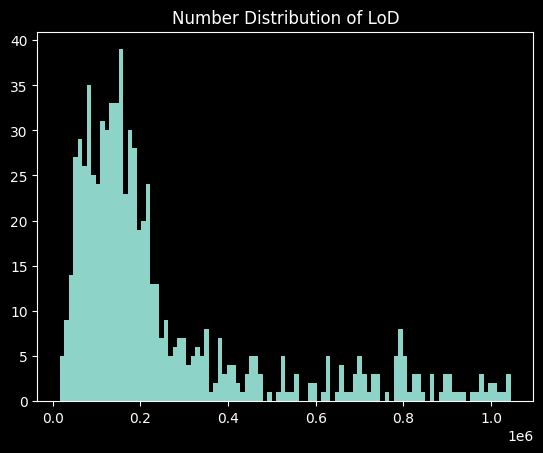

In [8]:
# plot histagram of visible_pts_cnt
plt.figure()
plt.hist(visible_pts_cnt, bins=100)
plt.title("Number Distribution of LoD")
plt.show()

In [21]:
views = scene.getTrainCameras()
idx = 333
viewpoint_cam = loadCam(lp, idx, views[idx], 1.0, angle_delta)
cam_center = viewpoint_cam.camera_center
image_height = viewpoint_cam.image_height
image_width = viewpoint_cam.image_width
xyz = lod_gs_2.feats[:, :3].float()

cell_corners = lod_gs_2.cell_corners
cell_corners = torch.cat([cell_corners, torch.ones_like(cell_corners[..., [0]])], dim=-1)
full_proj_transform = viewpoint_cam.full_proj_transform.repeat(lod_gs_2.num_cell, 1, 1)
viewmatrix = viewpoint_cam.world_view_transform.repeat(lod_gs_2.num_cell, 1, 1)
cell_corners_screen = cell_corners.bmm(full_proj_transform)
cell_corners_screen = cell_corners_screen / cell_corners_screen[..., [-1]]
cell_corners_screen = cell_corners_screen[..., :-1]
corners_screen_x = ((cell_corners_screen[..., 0] + 1.0) * image_width - 1.0) * 0.5
corners_screen_y = ((cell_corners_screen[..., 1] + 1.0) * image_height - 1.0) * 0.5

cell_corners_cam = cell_corners.bmm(viewmatrix)
mask = (cell_corners_cam[..., 2] > 0.2)

cell_corners_screen_min = torch.zeros((lod_gs_2.num_cell, 3), dtype=torch.float32, device=main_device)
cell_corners_screen_max = torch.zeros((lod_gs_2.num_cell, 3), dtype=torch.float32, device=main_device)

for i in range(lod_gs_2.num_cell):
    if mask[i].sum() > 0:
        cell_corners_screen_min[i] = cell_corners_screen[i][mask[i]].min(dim=0).values
        cell_corners_screen_max[i] = cell_corners_screen[i][mask[i]].max(dim=0).values

box_a = torch.cat([cell_corners_screen_min[:, :2], cell_corners_screen_max[:, :2]], dim=1)
box_b = torch.tensor([[-1, -1, 1, 1]], dtype=torch.float32, device=main_device)
A = box_a.size(0)
B = box_b.size(0)
max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                box_b[:, :2].unsqueeze(0).expand(A, B, 2))
inter = torch.clamp((max_xy - min_xy), min=0)
mask = (inter[:, 0, 0] * inter[:, 0, 1]) > 0

cam_center_id = which_block(cam_center[None, :], lod_gs_2.aabb, lod_gs_2.block_dim)[0]
mask[cam_center_id] = True

print(f"Available Cells for Image {idx}\n: {mask.nonzero().squeeze()}")

Available Cells for Image 333
: tensor([ 0,  3,  4,  5,  9, 10, 11, 16, 17], device='cuda:0')


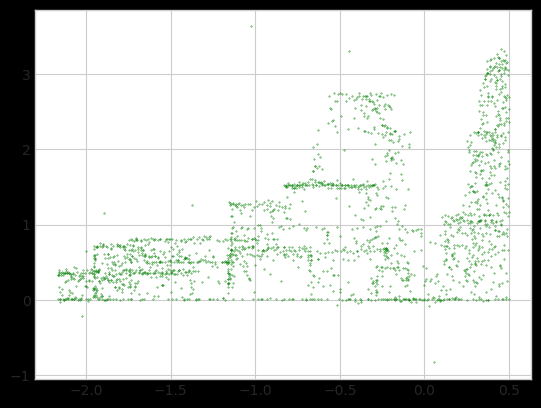

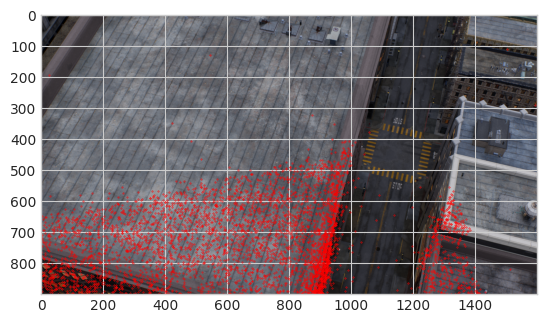

In [12]:
cell_id = 14
cell_xyz = xyz[lod_gs_2.cell_ids==cell_id]

plt.figure()
plt.style.use('seaborn-whitegrid')
# plt.axis('equal')
# plt.scatter(xyz[::100, 0].cpu(), xyz[::100, 1].cpu(), c='b', s=0.1)
plt.scatter(cell_xyz[::100, 0].cpu(),cell_xyz[::100, 2].cpu(), c='g', s=0.1)
# plt.scatter(cam_center[0].cpu(), cam_center[1].cpu(), c='r', s=20)
# plt.scatter(cell_corners[cell_id, :, 0].cpu(), cell_corners[cell_id, :, 1].cpu(), c='r', s=10, marker='x')
# plt.xlim(-10, 10)
# plt.ylim(-8, 7)
plt.show()

image_height = viewpoint_cam.image_height
image_width = viewpoint_cam.image_width
points_homo = torch.cat([cell_xyz, torch.ones_like(cell_xyz[..., [0]])], dim=-1)
points_screen = points_homo @ viewpoint_cam.full_proj_transform
points_screen = points_screen / points_screen[..., [-1]]
points_screen = points_screen[..., :-1]

mask = ((points_screen[..., 0] > -1) & (points_screen[..., 0] < 1) & (points_screen[..., 1] > -1) & (points_screen[..., 1] < 1))

points_screen_x = ((points_screen[mask, 0] + 1.0) * image_width - 1.0) * 0.5
points_screen_y = ((points_screen[mask, 1] + 1.0) * image_height - 1.0) * 0.5

image_path = os.path.join("../output/vox_mc_aerial_block_all_loss_avg_half_lr2_30k/block_all_test/ours_30000/gt", '{0:05d}'.format(idx) + ".png")

plt.figure()
plt.style.use('seaborn-whitegrid')
plt.imshow(plt.imread(image_path))
plt.scatter(points_screen_x.cpu(), points_screen_y.cpu(), c='r', s=0.1)
# plt.scatter(corners_screen_x[cell_id].cpu(), corners_screen_y[cell_id].cpu(), c='r', s=0.1)
plt.show()

## 6. Render the whole dataset without LoD

In [9]:
import time
import torchvision
from os import makedirs
from torch.profiler import profile, record_function, ProfilerActivity

In [11]:
iteration = 30_000

config = '../config/block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq.yaml'
config_name = os.path.splitext(os.path.basename(config))[0]
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    # cfg['model_params']['model_config']['name'] = "GaussianModel"
gaussians, scene = load_gaussians(cfg, config_name, iteration=None, load_vq=True, deivce='cuda')

lp, op, pp = parse_cfg(cfg)
setattr(lp, 'config_path', cfg)
lp.source_path = '../data/matrix_city/aerial/test/block_all_test'
scaling_modifier = 1.0
override_color = None
angle_delta = None

Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq with 11782801 points



In [12]:
angle_delta = np.array([0, 0, 0])
# indexing is the most time_consuming part
# model_path = os.path.join("../output/", "block_mc_aerial_block_all_lr_c36_loss_5")
# name = "block_all_test"
# render_path = os.path.join(model_path, name, "ours_{}".format(iteration), "renders")
# gts_path = os.path.join(model_path, name, "ours_{}".format(iteration), "gt")

# makedirs(render_path, exist_ok=True)
# makedirs(gts_path, exist_ok=True)
torch.cuda.empty_cache()

In [13]:
with torch.no_grad():
    
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    avg_render_time = 0
    max_render_time = 0
    visible_pts_cnt_single = []

    for idx in tqdm(range(len(views))):
        
        viewpoint_cam = loadCam(lp, idx, views[idx], 1.0, angle_delta)
        start = time.time()

        render_pkg = render(viewpoint_cam, gaussians, pp, background)
        visible_pts_cnt_single.append(render_pkg['visibility_filter'].sum().item())

        end = time.time()
        avg_render_time += end-start
        max_render_time = max(max_render_time, end-start)

        # torchvision.utils.save_image(render_pkg["render"], os.path.join(render_path, '{0:05d}'.format(idx) + ".png"))
        # torchvision.utils.save_image(viewpoint_cam.original_image[0:3, :, :], os.path.join(gts_path, '{0:05d}'.format(idx) + ".png"))

    print(f'Average FPS: {len(views)/avg_render_time:.4f}')
    print(f'Min FPS: {1/max_render_time:.4f}')
    # print(f'Max memory: {max_memory/1024**3:.4f}GB')

100%|██████████| 741/741 [05:06<00:00,  2.42it/s]

Average FPS: 29.5364
Min FPS: 2.4446


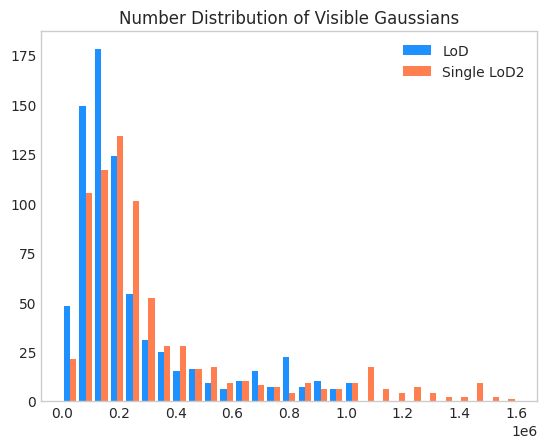

In [24]:
# plot histagram of visible_pts_cnt
plt.figure()
plt.style.use('seaborn-whitegrid')

bins = np.linspace(0, 1.6e6, 30)
plt.hist([visible_pts_cnt, visible_pts_cnt_single], bins, label=['LoD', 'Single LoD2'], color=['dodgerblue', 'coral'])
plt.title("Number Distribution of Visible Gaussians")
plt.legend(loc='upper right')
plt.grid(False)
plt.show()